In [1]:
# !pip install s2sphere
# !pip install mapsplotlib

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
import s2sphere

In [2]:
conf = SparkConf().setAppName("msds697_project")
sc = SparkContext(conf=conf)
sc.setLogLevel("OFF")

In [3]:
ss = SparkSession.builder.getOrCreate()

# NYC data

## Import data and preprocess

In [4]:
def toFloatSafe(v):
    try:
        return float(v)
    except ValueError:
        return v

In [5]:
nyc_header = "vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,End_Lat,Payment_Type,Fare_Amt,surcharge,mta_tax,Tip_Amt,Tolls_Amt,Total_Amt".split(",")

nyc_data = sc.textFile("data/nyc_data.csv")\
             .map(lambda x:  x.split(","))\
             .filter(lambda x: (len(x) == len(nyc_header)) & (x != nyc_header))\
             .map(lambda x: [toFloatSafe(v) for v in x])

keep_cols = ['trip_pickup_datetime',
 'trip_dropoff_datetime',
 'trip_distance',
 'start_lon',
 'start_lat',
 'end_lon',
 'end_lat']

In [6]:
NY_lat_min = 40.70
NY_lat_max = 40.87
NY_long_max = -73.92
NY_long_min = -74.00

nyc_data = nyc_data.filter(lambda x: (x[10] >= NY_lat_min) & (x[10] <= NY_lat_max))\
                 .filter(lambda x: (x[6] >= NY_lat_min) & (x[6] <= NY_lat_max))\
                 .filter(lambda x: (x[5] >= NY_long_min) & (x[5] <= NY_long_max))\
                 .filter(lambda x: (x[9] >= NY_long_min) & (x[9] <= NY_long_max))

In [7]:
nyc_df = nyc_data.toDF([x.lower() for x in nyc_header])
nyc_df = nyc_df.select(keep_cols)

In [13]:
import matplotlib.pyplot as plt

In [ ]:
# nyc_pydf = nyc_df.toPandas()
# Error:java.lang.OutOfMemoryError: GC overhead limit exceeded

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(sf_data.long_x, sf_data.lat_x, s=10, lw=0, alpha=0.8)
ax.set_xlim(SF_long_min, SF_long_max)
ax.set_ylim(SF_lat_min, SF_lat_max)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(sf_data.long_y, sf_data.lat_y, s=10, lw=0, alpha=0.8)
ax.set_xlim(SF_long_min, SF_long_max)
ax.set_ylim(SF_lat_min, SF_lat_max)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [8]:
nyc_df.printSchema()

root
 |-- trip_pickup_datetime: string (nullable = true)
 |-- trip_dropoff_datetime: string (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- start_lon: double (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- end_lon: double (nullable = true)
 |-- end_lat: double (nullable = true)



In [9]:
nyc_df.take(5)

[Row(trip_pickup_datetime='2009-01-04 03:31:00', trip_dropoff_datetime='2009-01-04 03:38:00', trip_distance=4.55, start_lon=-73.982102, start_lat=40.73629, end_lon=-73.95585, end_lat=40.76803),
 Row(trip_pickup_datetime='2009-01-01 20:52:58', trip_dropoff_datetime='2009-01-01 21:14:00', trip_distance=5.0, start_lon=-73.974267, start_lat=40.790955, end_lon=-73.996558, end_lat=40.731849),
 Row(trip_pickup_datetime='2009-01-16 22:35:59', trip_dropoff_datetime='2009-01-16 22:43:35', trip_distance=1.2, start_lon=-73.989806, start_lat=40.735006, end_lon=-73.985021, end_lat=40.724494),
 Row(trip_pickup_datetime='2009-01-21 08:55:57', trip_dropoff_datetime='2009-01-21 09:05:42', trip_distance=0.4, start_lon=-73.98405, start_lat=40.743544, end_lon=-73.98026, end_lat=40.748926),
 Row(trip_pickup_datetime='2009-01-04 04:31:00', trip_dropoff_datetime='2009-01-04 04:36:00', trip_distance=1.72, start_lon=-73.992635, start_lat=40.748362, end_lon=-73.995585, end_lat=40.728307)]

In [10]:
def lowercase_cols(df):
    for col in df.columns:
        new_col = col.lower()
        if new_col != col:
            df = df.withColumnRenamed(col, new_col)
    return df

def toDatetime(df, col_name):
    df = df.withColumn(col_name + "_2", to_timestamp(df[col_name], 'yyyy-MM-dd HH:mm:ss'))
    df = df.drop(col_name).withColumnRenamed(col_name + "_2", col_name)
    return df

nyc_df = lowercase_cols(nyc_df)

Extract day of week, add "is_weekend" flag when trip starts OR ends during the weekend

## Trip-level features

In [11]:
cell_level = 13

def coord_to_id_fun(x, cell_level=cell_level):
    lat, lon = x
    from s2sphere import CellId, LatLng
    cell_id = CellId.from_lat_lng(LatLng.from_degrees(lat, lon))\
    .parent(cell_level).to_token()
    return cell_id

def get_corners(s2CellId_str, cell_level=cell_level+1, cluster=1):
    from s2sphere import CellId, LatLng, Cell
    c1 = Cell(CellId(int(s2CellId_str,16)<<(60 - 2*cell_level)))
    v0 = LatLng.from_point(c1.get_vertex(0)) # lat/lon of upper/left corner
    v1 = LatLng.from_point(c1.get_vertex(1)) # lat/lon of lower/left corner
    v2 = LatLng.from_point(c1.get_vertex(2)) # lat/lon of lower/right corner
    v3 = LatLng.from_point(c1.get_vertex(3)) # lat/lon of upper/right corner
    return ((v0.lat().degrees, v0.lng().degrees, cluster),
            (v1.lat().degrees, v1.lng().degrees, cluster),
            (v2.lat().degrees, v2.lng().degrees, cluster),
            (v3.lat().degrees, v3.lng().degrees, cluster))

def distance_fun(x):
    import math
    lat1, lon1, lat2, lon2 = x
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

coord_to_id = udf(lambda x: coord_to_id_fun(x), StringType())
distance = udf(lambda x: distance_fun(x), FloatType())

In [30]:
from pyspark.sql import functions as F

def process_features(df):
    df = toDatetime(df, "trip_pickup_datetime")
    df = toDatetime(df, "trip_dropoff_datetime")

    df = df.withColumn('dow_dropoff', date_format('trip_dropoff_datetime', 'u').cast(IntegerType()))\
    .withColumn('strdow_dropoff', date_format('trip_dropoff_datetime', 'E'))\
    .withColumn('dow_pickup', date_format('trip_pickup_datetime', 'u').cast(IntegerType()))\
    .withColumn('strdow_pickup', date_format('trip_pickup_datetime', 'E'))\
    .withColumn('hour_pickup', date_format('trip_pickup_datetime', 'H').cast(IntegerType()))\
    .withColumn('hour_dropoff', date_format('trip_dropoff_datetime', 'H').cast(IntegerType()))

    df = df.withColumn("is_weekend", when((df.dow_pickup >= 6) | (df.dow_dropoff >= 6), 1).otherwise(0))

    df = df.withColumn("start_cell_id", coord_to_id(array("start_lat", "start_lon")))
    df = df.withColumn("end_cell_id", coord_to_id(array("end_lat", "end_lon")))
    df = df.withColumn("distance_km", distance(array("start_lat", "start_lon","end_lat", "end_lon")))


    timeFmt = "yyyy-MM-dd HH:mm:ss"
    timediff = (F.unix_timestamp('trip_dropoff_datetime', format=timeFmt)
                - F.unix_timestamp('trip_pickup_datetime', format=timeFmt))
    df = df.withColumn("trip_duration", timediff)

    return df

In [31]:
nyc_df = process_features(nyc_df)
nyc_df.cache()

DataFrame[trip_distance: double, start_lon: double, start_lat: double, end_lon: double, end_lat: double, dow_dropoff: int, strdow_dropoff: string, dow_pickup: int, strdow_pickup: string, hour_pickup: int, hour_dropoff: int, is_weekend: int, start_cell_id: string, end_cell_id: string, distance_km: float, trip_pickup_datetime: timestamp, trip_dropoff_datetime: timestamp, trip_duration: bigint]

In [67]:
nyc_df.approxQuantile("trip_duration", [.0], 0)

Py4JJavaError: An error occurred while calling o1183.approxQuantile.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 29.0 failed 1 times, most recent failure: Lost task 2.0 in stage 29.0 (TID 272, localhost, executor driver): java.lang.OutOfMemoryError: Java heap space

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1602)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1590)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1589)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1589)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1823)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1772)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1761)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2131)
	at org.apache.spark.rdd.RDD$$anonfun$fold$1.apply(RDD.scala:1092)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1086)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1131)
	at org.apache.spark.sql.execution.stat.StatFunctions$.multipleApproxQuantiles(StatFunctions.scala:102)
	at org.apache.spark.sql.DataFrameStatFunctions.approxQuantile(DataFrameStatFunctions.scala:100)
	at org.apache.spark.sql.DataFrameStatFunctions.approxQuantile(DataFrameStatFunctions.scala:115)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: Java heap space


In [ ]:
nyc_df.approxQuantile("trip_duration", [0.01], 0)

In [ ]:
nyc_df.approxQuantile("trip_duration", [0.99], 0)

In [ ]:
nyc_df.approxQuantile("trip_duration", [1.], 0)

In [ ]:
nyc_df = nyc_df.filter(nyc_df.trip_duration <= 1800)\
               .filter(nyc_df.trip_duration >= 30)

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 59580)
Traceback (most recent call last):
  File "/Users/crystal/anaconda3/envs/MSDS694/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/crystal/anaconda3/envs/MSDS694/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/Users/crystal/anaconda3/envs/MSDS694/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/crystal/anaconda3/envs/MSDS694/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/Users/crystal/anaconda3/envs/MSDS694/lib/python3.6/site-packages/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/Users/crystal/anaconda3/envs/MSDS694/lib/python3.6/site-packages/pyspark/seri

In [25]:
temp = nyc_df.withColumn("factor", nyc_df.trip_distance/nyc_df.distance_km)
nyc_factor = temp.agg(avg(temp.factor).alias('factor'))
nyc_factor = nyc_factor.toPandas()
nyc_factor = nyc_factor.factor[0]
nyc_factor

2.1771028306201075

## Divide areas into cells

In [24]:
nyc_df = nyc_df.withColumn("start_cell_id", coord_to_id(array("start_lat", "start_lon")))
nyc_df = nyc_df.withColumn("end_cell_id", coord_to_id(array("end_lat", "end_lon")))
nyc_df = nyc_df.withColumn("distance_km", distance(array("start_lat", "start_lon","end_lat", "end_lon")))
nyc_df.cache()

DataFrame[trip_distance: double, start_lon: double, start_lat: double, end_lon: double, end_lat: double, trip_pickup_datetime: timestamp, trip_dropoff_datetime: timestamp, dow_dropoff: int, strdow_dropoff: string, dow_pickup: int, strdow_pickup: string, hour_pickup: int, hour_dropoff: int, is_weekend: int, start_cell_id: string, end_cell_id: string, distance_km: float]

In [25]:
%%time
nyc_df.count()

CPU times: user 130 ms, sys: 79.4 ms, total: 210 ms
Wall time: 5h 27min 11s


14092413

### Save or Load featured data

In [ ]:
# nyc_df.write.csv("nyc_df")
nyc_pddf = nyc_df.toPandas()
nyc_pddf.to_csv('./data/nyc_df.csv')

In [14]:
new_schema = StructType([StructField("trip_distance",DoubleType(),True),
           StructField("start_lon",DoubleType(),True),
           StructField("start_lat",DoubleType(),True),
           StructField("end_lon",DoubleType(),True),
           StructField("end_lat",DoubleType(),True),
           StructField("trip_pickup_datetime",StringType(),True),
           StructField("trip_dropoff_datetime",StringType(),True),
           StructField("dow_dropoff",IntegerType(),True),
           StructField("strdow_dropoff",StringType(),True),
           StructField("dow_pickup",IntegerType(),True),
           StructField("strdow_pickup",StringType(),True),
           StructField("hour_pickup",IntegerType(),True),
           StructField("hour_dropoff",IntegerType(),True),
           StructField("is_weekend",IntegerType(),True),
           StructField("start_cell_id",StringType(),True),
           StructField("end_cell_id",StringType(),True),
           StructField("distance_km",FloatType(),True)])

nyc_df = ss.read.csv('data/nyc_df.csv/', header=True, schema=new_schema)

In [16]:
nyc_df.take(5)

[Row(trip_distance=None, start_lon=None, start_lat=None, end_lon=None, end_lat=None, trip_pickup_datetime=None, trip_dropoff_datetime=None, dow_dropoff=None, strdow_dropoff=None, dow_pickup=None, strdow_pickup=None, hour_pickup=None, hour_dropoff=None, is_weekend=None, start_cell_id=None, end_cell_id=None, distance_km=None),
 Row(trip_distance=None, start_lon=None, start_lat=None, end_lon=None, end_lat=None, trip_pickup_datetime=None, trip_dropoff_datetime=None, dow_dropoff=None, strdow_dropoff=None, dow_pickup=None, strdow_pickup=None, hour_pickup=None, hour_dropoff=None, is_weekend=None, start_cell_id=None, end_cell_id=None, distance_km=None),
 Row(trip_distance=None, start_lon=None, start_lat=None, end_lon=None, end_lat=None, trip_pickup_datetime=None, trip_dropoff_datetime=None, dow_dropoff=None, strdow_dropoff=None, dow_pickup=None, strdow_pickup=None, hour_pickup=None, hour_dropoff=None, is_weekend=None, start_cell_id=None, end_cell_id=None, distance_km=None),
 Row(trip_distance=

## Gather features by cell

In [57]:
def pivot_column(df, group_col, pv_col, prefix):
    orig_cols = set(df.columns)
    new_df = df.groupBy(group_col).pivot(pv_col).count()
    new_cols = new_df.columns
    new_cols = [c if c in orig_cols else prefix + c for c in new_cols]
    new_df = new_df.toDF(*new_cols)
    new_df = new_df.na.fill(0, list(set(new_cols) - orig_cols))
    return new_df

In [61]:
def merge_dfs(dfs):
    first_df = None
    for df in dfs:
        if first_df is None:
            first_df = df
        else:
            first_df = first_df.join(df, "cell_id", "left_outer")
    return first_df

In [58]:
def create_features(df):
    dow_pickup_df = pivot_column(df, group_col = "start_cell_id", 
                                     pv_col = "dow_pickup", prefix = "dow_pickup_")\
                                     .withColumnRenamed("start_cell_id", "cell_id")

    dow_dropoff_df = pivot_column(df, group_col = "end_cell_id", 
                                      pv_col = "dow_dropoff", prefix = "dow_dropoff_")\
                                      .withColumnRenamed("end_cell_id", "cell_id")

    hr_pickup_wkday_df = pivot_column(df.filter(df.dow_pickup<6), 
                                                               group_col = "start_cell_id", 
                                                               pv_col = "hour_pickup", 
                                                               prefix = "hr_pickup_wkday")\
                                                               .withColumnRenamed("start_cell_id", "cell_id")

    hr_dropoff_wkday_df = pivot_column(df.filter(df.dow_dropoff<6), 
                                                               group_col = "end_cell_id", 
                                                               pv_col = "hour_dropoff", 
                                                               prefix = "hr_dropoff_wkday")\
                                                               .withColumnRenamed("end_cell_id", "cell_id")

    hr_pickup_wkend_df = pivot_column(df.filter(df.dow_pickup>=6), 
                                                               group_col = "start_cell_id", 
                                                               pv_col = "hour_pickup", 
                                                               prefix = "hr_pickup_wkend")\
                                                               .withColumnRenamed("start_cell_id", "cell_id")

    hr_dropoff_wkend_df = pivot_column(df.filter(df.dow_dropoff>=6), 
                                                               group_col = "end_cell_id", 
                                                               pv_col = "hour_dropoff", 
                                                               prefix = "hr_dropoff_wkend")\
                                                               .withColumnRenamed("end_cell_id", "cell_id")

    pickup_km_df = df.groupBy("start_cell_id").agg(avg("distance_km"),stddev("distance_km"))\
                        .withColumnRenamed("avg(distance_km)", "avg_pickup_km")\
                        .withColumnRenamed("stddev_samp(distance_km)", "std_pickup_km")\
                        .withColumnRenamed("start_cell_id", "cell_id")

    dropoff_km_df = df.groupBy("end_cell_id").agg(avg("distance_km"),stddev("distance_km"))\
                        .withColumnRenamed("avg(distance_km)", "avg_dropoff_km")\
                        .withColumnRenamed("stddev_samp(distance_km)", "std_dropoff_km")\
                        .withColumnRenamed("end_cell_id", "cell_id")
    
    discrete_pickup_cell_no = df.groupBy("end_cell_id")\
                                .agg(countDistinct("start_cell_id").alias("discrete_pickup_cell_no"))\
                                .withColumnRenamed("end_cell_id", "cell_id")
    
    discrete_dropoff_cell_no = df.groupBy("start_cell_id")\
                                .agg(countDistinct("end_cell_id").alias("discrete_dropoff_cell_no"))\
                                .withColumnRenamed("start_cell_id", "cell_id")

    cell_df = merge_dfs([dow_pickup_df, dow_dropoff_df, 
              hr_pickup_wkday_df, hr_dropoff_wkday_df,
              hr_pickup_wkend_df, hr_dropoff_wkend_df,
              pickup_km_df, dropoff_km_df,
              discrete_pickup_cell_no, discrete_dropoff_cell_no
             ])

    cell_df = cell_df.na.fill(0)

    cell_df.printSchema()
    
    feature_columns = [c for c in cell_df.columns if c != "cell_id"]

    for c in feature_columns:
        cell_df = cell_df.withColumn(c+"_f", cell_df[c].cast(FloatType()))
        cell_df = cell_df.drop(c)
        cell_df = cell_df.withColumnRenamed(c+"_f",c)

    cell_df.cache()

    print(cell_df.count(), len(cell_df.columns))

    return cell_df

In [ ]:
nyc_cell_df = create_features(nyc_df)
nyc_cell_df.cache()

In [88]:
(nyc_cell_df.count(), len(nyc_cell_df.columns))

(6174, 115)

## Vectorize features

In [238]:
from pyspark.ml.feature import StandardScaler

def vectorize(cell_df, city):
    feature_columns = [c for c in cell_df.columns if c != "cell_id"]
    va = VectorAssembler(outputCol="features", inputCols=feature_columns)
    vectorized_df = va.transform(cell_df)
    vectorized_df = vectorized_df.select("features")

    scaler = StandardScaler(inputCol="features",\
             outputCol="scaledFeatures")
    scalerModel =  scaler.fit(vectorized_df)
    vectorized_df = scalerModel.transform(vectorized_df)
    
    vectorized_df = vectorized_df.withColumn('row_index', monotonically_increasing_id())
    cell_df = cell_df.withColumn('row_index', monotonically_increasing_id())
    vectorized_df = vectorized_df.join(cell_df.select("row_index", "cell_id"), on=["row_index"]).sort("row_index").drop("row_index")
    vectorized_df = vectorized_df.withColumn("city", lit(city))

    return vectorized_df

In [239]:
%%time
nyc_vectorized_df = vectorize(nyc_cell_df, city="NY")
nyc_vectorized_df.cache()
nyc_vectorized_df.count()

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 12.8 s


In [240]:
nyc_vectorized_df.show(2)

+--------------------+--------------------+--------+----+
|            features|      scaledFeatures| cell_id|city|
+--------------------+--------------------+--------+----+
|(114,[5,82,110],[...|(114,[5,82,110],[...|87e9702c|  NY|
|(114,[5,83,110],[...|(114,[5,83,110],[...|89b1105c|  NY|
+--------------------+--------------------+--------+----+
only showing top 2 rows



## Plotting

### Common outbound cells

In [325]:
nyc_popular_cell_id = nyc_df.groupBy("end_cell_id").count().orderBy("count", ascending=False).first().end_cell_id
nyc_unpopular_cell_id = nyc_df.groupBy("end_cell_id").count().orderBy("count", ascending=True).first().end_cell_id

In [83]:
%matplotlib inline

import pandas as pd
import numpy as np
from mapsplotlib import mapsplot as mplt
import constants as c
mplt.register_api_key(c.google_maps_key)

def show_cell(cell_id, cell_level=cell_level+1):
    map_data = get_corners(cell_id, cell_level=14)
    map_df = pd.DataFrame(np.array(map_data), columns=["latitude", "longitude", "cluster"])
    map_df.cluster = map_df.cluster.astype(np.int)
    mplt.polygons(map_df['latitude'], map_df['longitude'], map_df['cluster'])

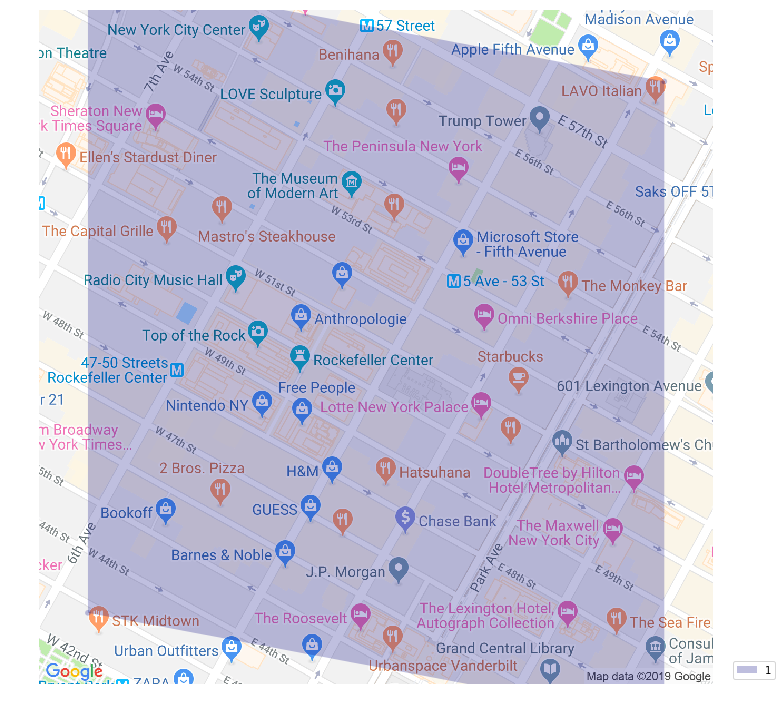

In [100]:
show_cell(popular_cell_id)

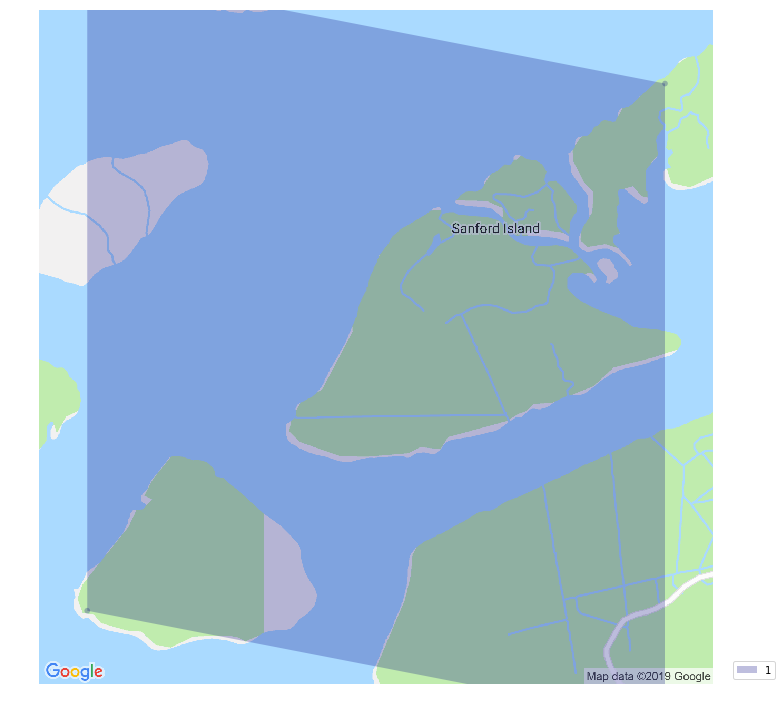

In [85]:
show_cell(unpopular_cell_id)

# SF Data

In [17]:
sf_header = "lat_y,long_y,lat_x,long_x,dt_ts_y,dt_ts_x".split(",")

sf_new_header = ['end_lat',
             'end_lon',
             'start_lat',
             'start_lon',
             'trip_dropoff_datetime',
             'trip_pickup_datetime']

sf_data = sc.textFile("data/sf_data.csv")\
            .map(lambda x:  x.split(","))\
            .filter(lambda x: (len(x) == len(sf_header)) & (x != sf_header))\
            .map(lambda x: [toFloatSafe(v) for v in x])

In [18]:
SF_lat_min = 37.71
SF_lat_max = 37.82
SF_long_max = -122.36
SF_long_min = -122.52

sf_data = sf_data.filter(lambda x: (x[0] >= SF_lat_min) & (x[0] <= SF_lat_max))\
                 .filter(lambda x: (x[2] >= SF_lat_min) & (x[2] <= SF_lat_max))\
                 .filter(lambda x: (x[1] >= SF_long_min) & (x[1] <= SF_long_max))\
                 .filter(lambda x: (x[3] >= SF_long_min) & (x[3] <= SF_long_max))

In [19]:
sf_df = sf_data.toDF(sf_new_header)

In [20]:
sf_pddf = sf_df.toPandas()

In [28]:
sf_pddf.head(5)

,end_lat,end_lon,start_lat,start_lon,trip_dropoff_datetime,trip_pickup_datetime
0,37.75552,-122.41438,37.74977,-122.39724,2008-05-17 07:55:58,2008-05-17 07:51:10
1,37.75177,-122.43095,37.75053,-122.42086,2008-05-17 08:21:48,2008-05-17 08:18:06
2,37.77188,-122.41825,37.77173,-122.41838,2008-05-17 08:45:51,2008-05-17 08:43:51
3,37.79160,-122.41249,37.75240,-122.41842,2008-05-17 09:34:28,2008-05-17 09:18:40
4,37.74669,-122.40395,37.73335,-122.40556,2008-05-17 10:29:15,2008-05-17 10:27:23


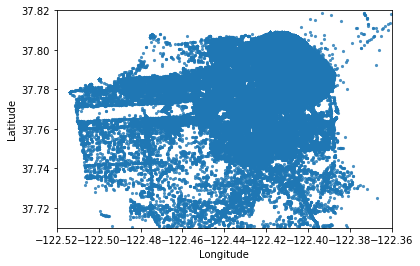

In [21]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(sf_pddf.start_lon, sf_pddf.start_lat, s=10, lw=0, alpha=0.8)
ax.set_xlim(SF_long_min, SF_long_max)
ax.set_ylim(SF_lat_min, SF_lat_max)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

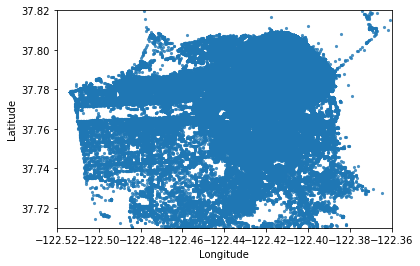

In [22]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(sf_pddf.end_lon, sf_pddf.end_lat, s=10, lw=0, alpha=0.8)
ax.set_xlim(SF_long_min, SF_long_max)
ax.set_ylim(SF_lat_min, SF_lat_max)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

## Trip-level features

In [61]:
sf_df = process_features(sf_df)
sf_df = sf_df.withColumn("trip_distance", nyc_factor*sf_df.distance_km)
sf_df.cache()

DataFrame[end_lat: double, end_lon: double, start_lat: double, start_lon: double, dow_dropoff: int, strdow_dropoff: string, dow_pickup: int, strdow_pickup: string, hour_pickup: int, hour_dropoff: int, is_weekend: int, start_cell_id: string, end_cell_id: string, distance_km: float, trip_distance: double, trip_duration: bigint, trip_pickup_datetime: timestamp, trip_dropoff_datetime: timestamp]

In [62]:
sf_df.approxQuantile("trip_duration", [.0], 0)

[30.0]

In [63]:
sf_df.approxQuantile("trip_duration", [0.01], 0)

[60.0]

In [64]:
sf_df.approxQuantile("trip_duration", [0.99], 0)

[1454.0]

In [65]:
sf_df.approxQuantile("trip_duration", [1.], 0)

[1800.0]

In [68]:
sf_df = sf_df.filter(sf_df.trip_duration <= 1800)\
             .filter(sf_df.trip_duration >= 30)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/Users/crystal/anaconda3/envs/MSDS694/lib/python3.6/site-packages/py4j/java_gateway.py", line 1152, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/crystal/anaconda3/envs/MSDS694/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [Errno 54] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/crystal/anaconda3/envs/MSDS694/lib/python3.6/site-packages/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/Users/crystal/anaconda3/envs/MSDS694/lib/python3.6/site-packages/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving


Py4JError: An error occurred while calling o1178.schema

In [ ]:
%%time
sf_df.count()

In [ ]:
sf_pddf = sf_df.toPandas()
sf_pddf.to_csv('./data/sf_df.csv')

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(sf_pddf.start_lon, sf_pddf.start_lat, s=10, lw=0, alpha=0.8)
ax.set_xlim(SF_long_min, SF_long_max)
ax.set_ylim(SF_lat_min, SF_lat_max)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(sf_pddf.end_lon, sf_pddf.end_lat, s=10, lw=0, alpha=0.8)
ax.set_xlim(SF_long_min, SF_long_max)
ax.set_ylim(SF_lat_min, SF_lat_max)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

## Create cell features

In [62]:
%%time
sf_cell_df = create_features(sf_df)
sf_cell_df.cache()
sf_cell_df.count()

root
 |-- cell_id: string (nullable = true)
 |-- dow_pickup_1: long (nullable = true)
 |-- dow_pickup_2: long (nullable = true)
 |-- dow_pickup_3: long (nullable = true)
 |-- dow_pickup_4: long (nullable = true)
 |-- dow_pickup_5: long (nullable = true)
 |-- dow_pickup_6: long (nullable = true)
 |-- dow_pickup_7: long (nullable = true)
 |-- dow_dropoff_1: long (nullable = true)
 |-- dow_dropoff_2: long (nullable = true)
 |-- dow_dropoff_3: long (nullable = true)
 |-- dow_dropoff_4: long (nullable = true)
 |-- dow_dropoff_5: long (nullable = true)
 |-- dow_dropoff_6: long (nullable = true)
 |-- dow_dropoff_7: long (nullable = true)
 |-- hr_pickup_wkday0: long (nullable = true)
 |-- hr_pickup_wkday1: long (nullable = true)
 |-- hr_pickup_wkday2: long (nullable = true)
 |-- hr_pickup_wkday3: long (nullable = true)
 |-- hr_pickup_wkday4: long (nullable = true)
 |-- hr_pickup_wkday5: long (nullable = true)
 |-- hr_pickup_wkday6: long (nullable = true)
 |-- hr_pickup_wkday7: long (nullable =

In [241]:
%%time
sf_vectorized_df = vectorize(sf_cell_df, city="SF")
sf_vectorized_df.cache()
sf_vectorized_df.count()

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 11.4 s


## Plot

In [178]:
sf_popular_cell_id = sf_df.groupBy("end_cell_id").count().orderBy("count", ascending=False).first().asDict()["end_cell_id"]
sf_unpopular_cell_id = sf_df.groupBy("end_cell_id").count().orderBy("count", ascending=True).first().asDict()["end_cell_id"]

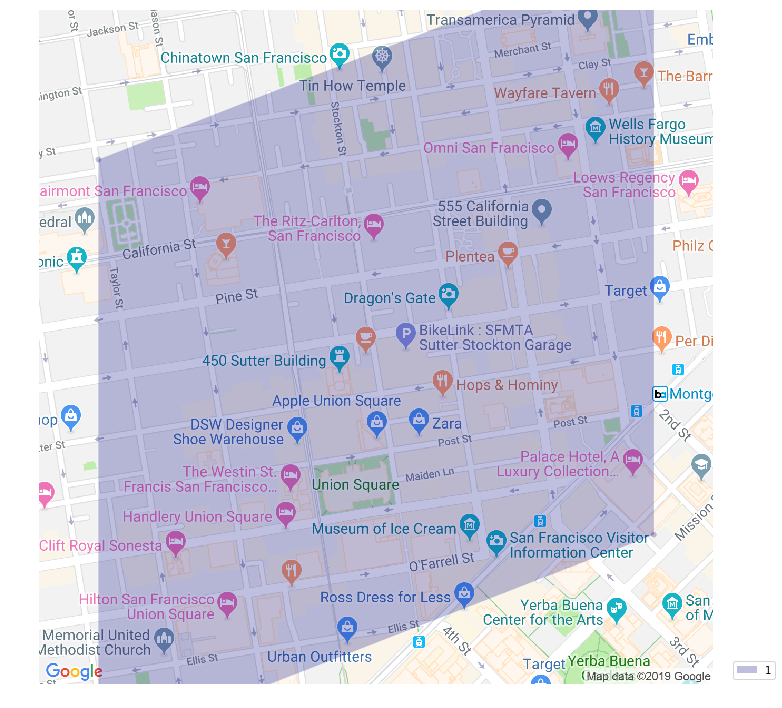

In [179]:
show_cell(sf_popular_cell_id)

In [181]:
sf_vectorized_df.show(2)

+--------------------+--------------------+----+
|            features|      scaledFeatures|city|
+--------------------+--------------------+----+
|(114,[0,1,3,7,8,9...|(114,[0,1,3,7,8,9...|  SF|
|(114,[3,12,13,37,...|(114,[3,12,13,37,...|  SF|
+--------------------+--------------------+----+
only showing top 2 rows



# Join SF and NYC Data

In [258]:
nyc_sf_df = nyc_vectorized_df.union(sf_vectorized_df)

In [259]:
nyc_vectorized_df.count(), sf_vectorized_df.count()

(6174, 547)

In [260]:
(nyc_sf_df.count(), len(nyc_sf_df.columns))

(6721, 4)

In [261]:
nyc_sf_df.show(2)

+--------------------+--------------------+--------+----+
|            features|      scaledFeatures| cell_id|city|
+--------------------+--------------------+--------+----+
|(114,[5,82,110],[...|(114,[5,82,110],[...|87e9702c|  NY|
|(114,[5,83,110],[...|(114,[5,83,110],[...|89b1105c|  NY|
+--------------------+--------------------+--------+----+
only showing top 2 rows



## Run clustering

In [293]:
from pyspark.ml.clustering import KMeans

In [268]:
%%time 
n_clusters = 300

kmeans = KMeans(k=n_clusters)
kmeans_model = kmeans.fit(nyc_sf_df.select("scaledFeatures").withColumnRenamed("scaledFeatures", "features"))

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 25.9 s


In [269]:
%%time 
nyc_sf_df = kmeans_model.transform(nyc_sf_df)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.88 s


In [294]:
score = kmeans_model.computeCost(nyc_sf_df)
print("Within Set Sum of Squared Errors = " + str(score))

Within Set Sum of Squared Errors = 2.42464761323e+12


### What are some examples of areas in the same cluster?

In [265]:
def vector_distance_fun(x, cluster_centers = kmeans_model.clusterCenters()):
    features, centroid = x
    centroid = cluster_centers[centroid]
    import math
    return math.sqrt(features.squared_distance(centroid))

In [266]:
vector_distance = udf(lambda x: vector_distance_fun(x), DoubleType())

In [271]:
%%time
distances_df = nyc_sf_df.withColumn("distance_from_centroid", vector_distance(struct("features", "prediction")))
distances_df.count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.73 s


In [272]:
distances_df.show(10)

+--------------------+--------------------+--------+----+----------+----------------------+
|            features|      scaledFeatures| cell_id|city|prediction|distance_from_centroid|
+--------------------+--------------------+--------+----+----------+----------------------+
|(114,[5,82,110],[...|(114,[5,82,110],[...|87e9702c|  NY|        81|    1643.6301457119366|
|(114,[5,83,110],[...|(114,[5,83,110],[...|89b1105c|  NY|       217|       9.1002835776777|
|(114,[2,35,110],[...|(114,[2,35,110],[...|89b117d4|  NY|       217|    10.189138450870066|
|(114,[2,9,31,55,1...|(114,[2,9,31,55,1...|89b45adc|  NY|        37|     87.09157934119494|
|(114,[6,81,110],[...|(114,[6,81,110],[...|89b69044|  NY|       134|    3.3802074565439164|
|(114,[6,83,110],[...|(114,[6,83,110],[...|89c14e7c|  NY|       107|     23.29423961065128|
|(114,[1,30,110],[...|(114,[1,30,110],[...|89c155ac|  NY|        81|    100.51549595019497|
|(114,[2,36,110],[...|(114,[2,36,110],[...|89c2053c|  NY|       206|     5.18411

In [332]:
from pyspark.sql.window import Window

w = Window.partitionBy(["prediction", "city"]).orderBy("distance_from_centroid")

distances_df = distances_df.withColumn('row_id', monotonically_increasing_id())

closest_distances_df = distances_df.withColumn("dist_id", 
                        first(distances_df.row_id).over(w)
                       ).filter("row_id = dist_id").\
select("city", "cell_id", "prediction", "distance_from_centroid")

closest_distances_df.orderBy("distance_from_centroid").show(3)

+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  NY|89c22d14|       278|    1.4142602781381497|
|  NY|89c71324|       294|     1.502108083743399|
|  SF|8085800c|       278|    2.1698102891084283|
+----+--------+----------+----------------------+
only showing top 3 rows



In [305]:
best_cluster = closest_distances_df.orderBy("distance_from_centroid").first().prediction

In [306]:
best_cluster

278

In [318]:
closest_distances_df.filter(closest_distances_df.prediction == best_cluster).show()

+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  NY|89c22d14|       278|    1.4142602781381497|
|  SF|8085800c|       278|    2.1698102891084283|
+----+--------+----------+----------------------+



In [314]:
rows = closest_distances_df.filter(closest_distances_df.prediction == best_cluster).select("cell_id").take(2)

In [315]:
cell_1, cell_2 = [r.cell_id for r in rows]
cell_1, cell_2

(u'89c22d14', u'8085800c')

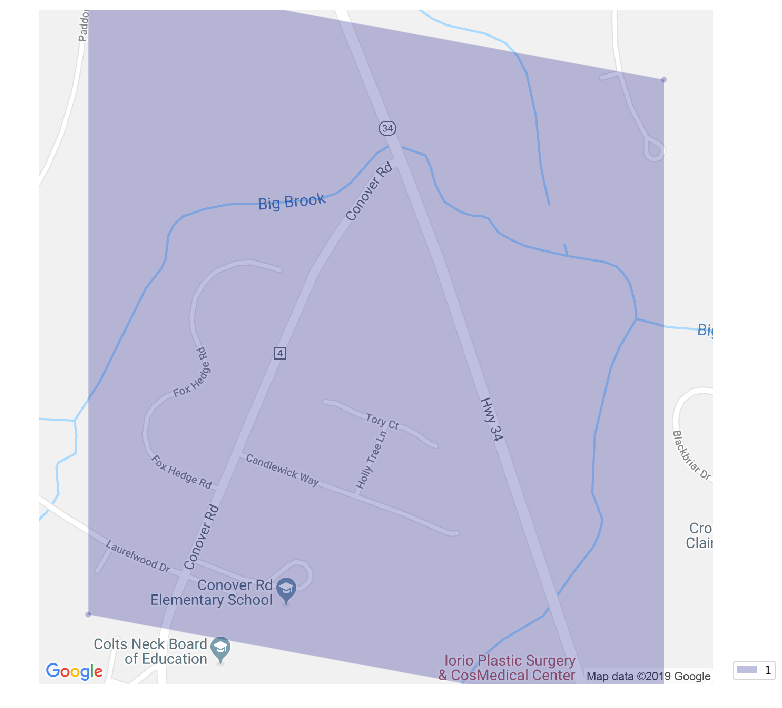

In [316]:
show_cell(cell_1)

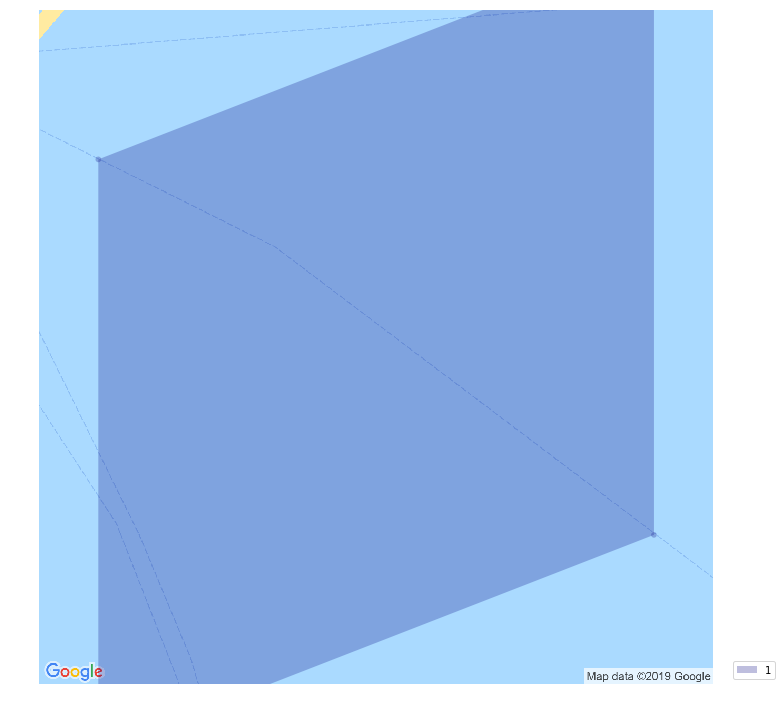

In [317]:
show_cell(cell_2)

### What part of SF is most similar to Times Square?

In [328]:
distances_df.filter(distances_df.cell_id == nyc_popular_cell_id).show()

+--------------------+--------------------+--------+----+----------+----------------------+-------------+
|            features|      scaledFeatures| cell_id|city|prediction|distance_from_centroid|       row_id|
+--------------------+--------------------+--------+----+----------+----------------------+-------------+
|[121479.0,146707....|[31.7114700421991...|89c258fc|  NY|         3|     607169.1208349548|1142461300751|
+--------------------+--------------------+--------+----+----------+----------------------+-------------+



In [331]:
distances_df.filter((distances_df.prediction == 3) & (distances_df.city == "SF")).orderBy("distance_from_centroid").show(1)

+--------------------+--------------------+--------+----+----------+----------------------+-------------+
|            features|      scaledFeatures| cell_id|city|prediction|distance_from_centroid|       row_id|
+--------------------+--------------------+--------+----+----------+----------------------+-------------+
|(114,[0,1,2,3,4,5...|(114,[0,1,2,3,4,5...|808f8504|  SF|         3|    354.05412101336424|1967095021569|
+--------------------+--------------------+--------+----+----------+----------------------+-------------+
only showing top 1 row



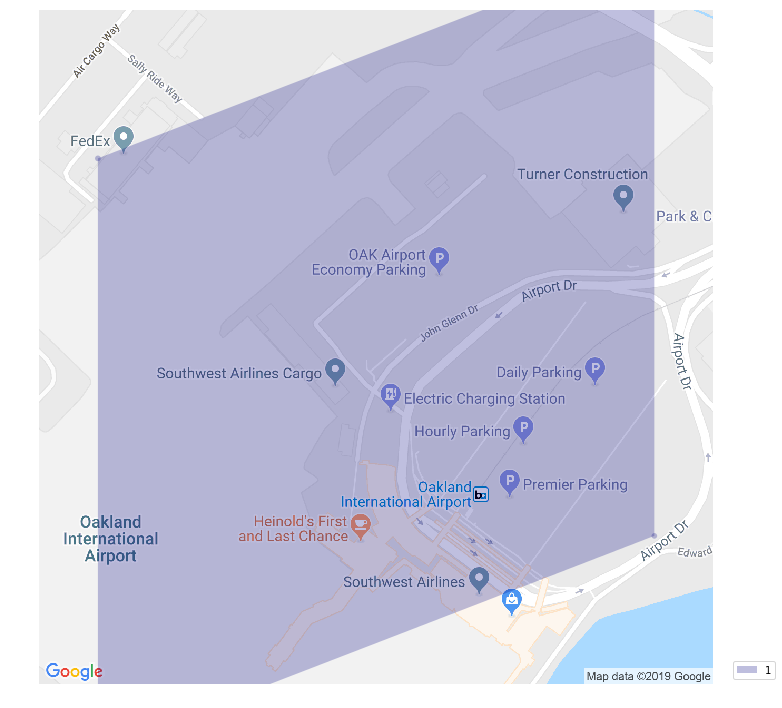

In [330]:
show_cell("808f8504")